# Evaluating CRM Dimensionality Reduction

This notebook tests the Contrastive Representation Module (CRM) for dimensionality reduction on the `lung` dataset. We will:
- Load the dataset and set up the data module.
- Pretrain the CRM using SimCLR.
- Visualize the latent representations using t-SNE.
- Compare classification performance with original and latent features.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.loggers import CSVLogger
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("./src") 

# Import custom modules (assuming they are in the same directory)
from dataset import DatasetModule, PretrainDataset, CustomPytorchDataset, load_lung, create_data_module, create_datamodule_with_cross_validation
from models import CRM, PretrainModel, SupConFineTuner
from main import parse_arguments

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

Global seed set to 42


42

## 1. Set Up Arguments

We define the arguments needed for the dataset, CRM, and pretraining. These mimic the command-line arguments from `main.py`.

In [73]:
# Parse arguments (simulate command-line args)
args = parse_arguments([
    '--dataset', 'toxicity',
    '--model', 'wpfs',
    '--run_repeats_and_cv',
    '--max_steps', '200',
    '--use_crm',
    '--use_supcon',
    '--train_on_full_data',
    '--experiment_name', 'toxicity_test_v4'
])

# Print key arguments to verify
print(f"Dataset: {args.dataset}")
print(f"CRM Latent Dim: {args.crm_latent_dim}")
print(f"Pretraining Epochs: {args.pretrain_epochs}")

Dataset: toxicity
CRM Latent Dim: 64
Pretraining Epochs: 100


## 2. Load and Prepare Data

Load the `lung` dataset and create the `DatasetModule`.

In [74]:
# Create data module with cross-validation
data_module = create_data_module(args)

print(f"Train Size: {args.train_size}")
print(f"Valid Size: {args.valid_size}")
print(f"Test Size: {args.test_size}")
print(f"Number of Features: {args.num_features}")
print(f"Class Weights: {args.class_weights}")

Train size: 122

Valid size: 14

Test size: 35

Weights for the classification loss: [0.9444444 0.9444444 1.0967742 1.030303 ]
Train Size: 136
Valid Size: 35
Test Size: 35
Number of Features: 5748
Class Weights: [0.9444444 0.9444444 1.0967742 1.030303 ]


## 3. Pretrain the CRM

Set up the pretraining dataset and model, then train the CRM using SimCLR and SupCon.

In [75]:
# Compute feature standard deviation for noise injection
feature_std = torch.from_numpy(np.std(data_module.X_train, axis=0)).float()

# Create pretraining dataset
pretrain_dataset = PretrainDataset(
    data_module.X_train,
    data_module.y_train,
    feature_std,
    p_mask=args.aug_p_mask,
    sigma_noise=args.aug_sigma_noise,
    p_synthetic=args.aug_p_synthetic,
    beta=args.aug_beta
)

# Create data loader
pretrain_loader = torch.utils.data.DataLoader(
    pretrain_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory
)

# Initialize CRM
crm = CRM(
    input_dim=args.num_features,
    hidden_dim=args.crm_hidden_dim,
    latent_dim=args.crm_latent_dim,
    proj_dim=args.crm_projector_dim
)

# Initialize pretraining model
pretrain_model = PretrainModel(args, crm)

# Set up logger
csv_logger = CSVLogger("logs", name=args.experiment_name)

# Create trainer
pretrain_trainer = pl.Trainer(
    max_epochs=args.pretrain_epochs,
    accelerator="auto",
    devices="auto",
    logger=csv_logger,
    callbacks=[RichProgressBar()],
    deterministic=True
)

# Train the CRM
pretrain_trainer.fit(pretrain_model, pretrain_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type    ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ 0 │ crm       │ CRM     │  746 K │
│ 1 │ criterion │ NT_Xent │      0 │
└───┴───────────┴─────────┴────────┘

Trainable params: 746 K                                                                      
Non-trainable params: 0                                                                      
Total params: 746 K                                                                          
Total estimated model params size (MB): 2

Output()

/home/pc114-ubuntu/anaconda3/envs/WPFS/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/pc114-ubuntu/anaconda3/envs/WPFS/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


In [76]:
# Freeze CRM
crm.eval()
crm.requires_grad_(False)

# Compute latent representations
with torch.no_grad():
    h_train_simclr, _ = crm(torch.tensor(data_module.X_train).float())
    h_valid_simclr, _ = crm(torch.tensor(data_module.X_valid).float())
    h_test_simclr, _ = crm(torch.tensor(data_module.X_test).float())

    h_train_simclr = h_train_simclr.cpu().numpy()
    h_valid_simclr = h_valid_simclr.cpu().numpy()
    h_test_simclr = h_test_simclr.cpu().numpy()

print(f"Latent Train Shape: {h_train_simclr.shape}")
print(f"Latent Valid Shape: {h_valid_simclr.shape}")
print(f"Latent Test Shape: {h_test_simclr.shape}")

Latent Train Shape: (136, 64)
Latent Valid Shape: (35, 64)
Latent Test Shape: (35, 64)


In [77]:
# Compute feature standard deviation for noise injection
feature_std = torch.from_numpy(np.std(data_module.X_train, axis=0)).float()

# Create pretraining dataset
pretrain_dataset = PretrainDataset(
    data_module.X_train,
    data_module.y_train,
    feature_std,
    p_mask=args.aug_p_mask,
    sigma_noise=args.aug_sigma_noise,
    p_synthetic=args.aug_p_synthetic,
    beta=args.aug_beta
)

# Create data loader
pretrain_loader = torch.utils.data.DataLoader(
    pretrain_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory
)

# Initialize CRM
crm = CRM(
    input_dim=args.num_features,
    hidden_dim=args.crm_hidden_dim,
    latent_dim=args.crm_latent_dim,
    proj_dim=args.crm_projector_dim
)

# Initialize pretraining model
pretrain_model = PretrainModel(args, crm)

# Set up logger
csv_logger = CSVLogger("logs", name=args.experiment_name)

# Create trainer
pretrain_trainer = pl.Trainer(
    max_epochs=args.pretrain_epochs,
    accelerator="auto",
    devices="auto",
    logger=csv_logger,
    callbacks=[RichProgressBar()],
    deterministic=True
)

# Train the CRM
pretrain_trainer.fit(pretrain_model, pretrain_loader)

# Fine-Tune with SupCon
supcon_model = SupConFineTuner(args, crm)
trainer = pl.Trainer(max_epochs=args.supcon_epochs, gpus=1)
trainer.fit(supcon_model, pretrain_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type    ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ 0 │ crm       │ CRM     │  746 K │
│ 1 │ criterion │ NT_Xent │      0 │
└───┴───────────┴─────────┴────────┘

Trainable params: 746 K                                                                      
Non-trainable params: 0                                                                      
Total params: 746 K                                                                          
Total estimated model params size (MB): 2

Output()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | crm       | CRM        | 746 K 
1 | criterion | SupConLoss | 0     
-----------------------------------------
746 K     Trainable params
0         Non-trainable params
746 K     Total params
2.986     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [78]:
# Freeze CRM
crm.eval()
crm.requires_grad_(False)

# Compute latent representations
with torch.no_grad():
    h_train_supcon, _ = crm(torch.tensor(data_module.X_train).float())
    h_valid_supcon, _ = crm(torch.tensor(data_module.X_valid).float())
    h_test_supcon, _ = crm(torch.tensor(data_module.X_test).float())

    h_train_supcon = h_train_supcon.cpu().numpy()
    h_valid_supcon = h_valid_supcon.cpu().numpy()
    h_test_supcon = h_test_supcon.cpu().numpy()

print(f"Latent Train Shape: {h_train_supcon.shape}")
print(f"Latent Valid Shape: {h_valid_supcon.shape}")
print(f"Latent Test Shape: {h_test_supcon.shape}")

Latent Train Shape: (136, 64)
Latent Valid Shape: (35, 64)
Latent Test Shape: (35, 64)


## 5. Visualize Latent Representations

Use t-SNE to visualize the latent representations and check if classes are separable.

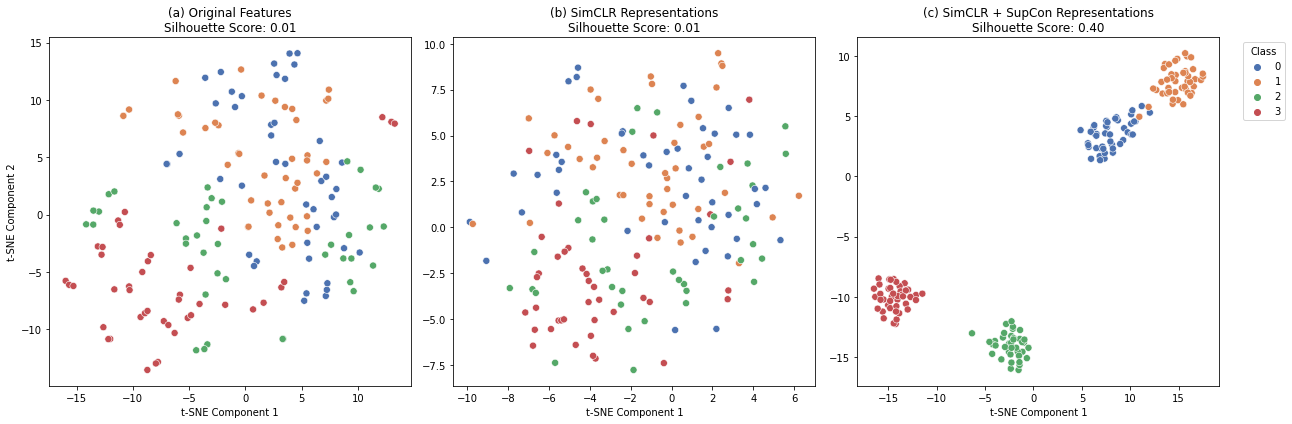

In [81]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ---- Original Features ----
h_all_orig = np.concatenate([data_module.X_train, data_module.X_test])
y_all = np.concatenate([data_module.y_train, data_module.y_test])
score_orig = silhouette_score(h_all_orig, y_all)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
h_2d_orig = tsne.fit_transform(h_all_orig)

sns.scatterplot(ax=axs[0], x=h_2d_orig[:, 0], y=h_2d_orig[:, 1], hue=y_all, palette='deep', s=50, legend=False)
axs[0].set_title(f'(a) Original Features\nSilhouette Score: {score_orig:.2f}')
axs[0].set_xlabel('t-SNE Component 1')
axs[0].set_ylabel('t-SNE Component 2')

# ---- SimCLR Features ----
h_all_simclr = np.concatenate([h_train_simclr, h_test_simclr])
score_simclr = silhouette_score(h_all_simclr, y_all)
h_2d_simclr = tsne.fit_transform(h_all_simclr)

sns.scatterplot(ax=axs[1], x=h_2d_simclr[:, 0], y=h_2d_simclr[:, 1], hue=y_all, palette='deep', s=50, legend=False)
axs[1].set_title(f'(b) SimCLR Representations\nSilhouette Score: {score_simclr:.2f}')
axs[1].set_xlabel('t-SNE Component 1')
axs[1].set_ylabel('')

# ---- SimCLR + SupCon Features ----
h_all_supcon = np.concatenate([h_train_supcon, h_test_supcon])
score_supcon = silhouette_score(h_all_supcon, y_all)
h_2d_supcon = tsne.fit_transform(h_all_supcon)

sns.scatterplot(ax=axs[2], x=h_2d_supcon[:, 0], y=h_2d_supcon[:, 1], hue=y_all, palette='deep', s=50)
axs[2].set_title(f'(c) SimCLR + SupCon Representations\nSilhouette Score: {score_supcon:.2f}')
axs[2].set_xlabel('t-SNE Component 1')
axs[2].set_ylabel('')
axs[2].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('embedding_quality.png')
plt.show()